In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### 1. Boundary value problem:
#### Bar with uniform charge


### (a)
$$w'' = \frac{S}{EI}w + \frac{qx}{2EI}(x-l), \hspace{5px} 0<x<l$$ 

In [4]:
S = 1000 #charge on the endpoints
E = 3e7 #elastic modulus
I = 625 #moment of inertia
l = 120 #length of bar
n = 100 #number of elements

h = l/(n+1)
x = [i*h for i in range(0,n+2)] #nodes

Method: finite elements


We will use the following family of functions to approximate the solution:
$$\varphi_i(x) = \begin{cases}
                    0, \hspace{5px} &x\leq x_{i-1},\\
                    \frac{x-x_{i-1}}{h}, \hspace{5px} &x_{i-1}\leq x \leq x_i,\\
                    \frac{x_{i+1}-x}{h}, \hspace{5px} &x_i\leq x \leq x_{i+1},\\
                    0, \hspace{5px} &x\leq x_{i+1},

                \end{cases}$$
With this we will get the following linear system of equations where $A$ is tridiagonal:

$$A = \begin{bmatrix}
    s & t &  &  &  & 0\\
    t & s & t &  &  & \\
     & t & \ddots &\ddots &  & \\
     &  & \ddots & \ddots & \ddots & \\
     &  &  & \ddots & \ddots & t\\
    0 &  &  & & t & s\\
    \end{bmatrix}
$$
$$s = \frac{2}{h}+\frac{2Sh}{3EI}$$
$$t = -\frac{1}{h} + \frac{Sh}{6EI} $$
$$b_i = \frac{-q}{2EI}\int_{x_{i-1}}^{x_{i+1}} \varphi_i(x^2-xl)dx$$


In [5]:
#solve tridiagonal system
def inverse_tridiagonal(A,b):
    n = len(A)
    x = np.zeros(n)
    for i in range(1,n):
        A[i,i] = A[i,i] - (A[i,i-1]/A[i-1,i-1])*A[i-1,i]
        b[i] = b[i] - (A[i,i-1]/A[i-1,i-1])*b[i-1]
    
    x[n-1] = b[n-1]/A[n-1,n-1]

    for i in range(n-2,1,-1):
        x[i] = (b[i]-A[i,i+1])/A[i,i]

    return x

In [6]:
s = 2/h + (2*S*h)/(3*E*I)
t = -1/h + (S*h)/(6*E*I)

#construct matrix A
A = np.zeros((n,n))
A[0,0] = s
A[0,1] = t
A[n-1,n-2] = t
A[n-1,n-1] = s

for i in range(1,n-1):
    A[i,i-1] = t
    A[i,i] = s
    A[i,i+1] = t

In [7]:
print(A[0][:3])
print(A[1][:3])
print(A[2][:4])
s

[ 1.68333338 -0.84166666  0.        ]
[-0.84166666  1.68333338 -0.84166666]
[ 0.         -0.84166666  1.68333338 -0.84166666]


1.6833333755775577

In [8]:
#construct vector b
def b_i_component(x, i, q, E, I, h, l):
    first_part = (x[i]**4/4 - (x[i]**3/3)*l - (x[i]**3/3)*x[i-1] - (x[i]**2/2)*l*x[i-1]) - (x[i-1]**4/4 - (x[i-1]**3/3)*l - (x[i-1]**3/3)*x[i-1] - (x[i-1]**2/2)*l*x[i-1])
    second_part = ((x[i+1]**3/3)*x[i+1] - (x[i+1]**2/2)*l*x[i+1] - (x[i+1]**4/4) + (x[i+1]**3/3)*l) - ((x[i]**3/3)*x[i+1] - (x[i]**2/2)*l*x[i+1] - (x[i]**4/4) + (x[i]**3/3)*l)
    return ((-q)/(2*E*I*h))*(first_part + second_part)

def b_vector(x, n, q, E, I, h, l):
    b = np.zeros(n)
    for i in range(0,n):
        b[i] = b_i_component(x, i, q, E, I, h, l)
    return b

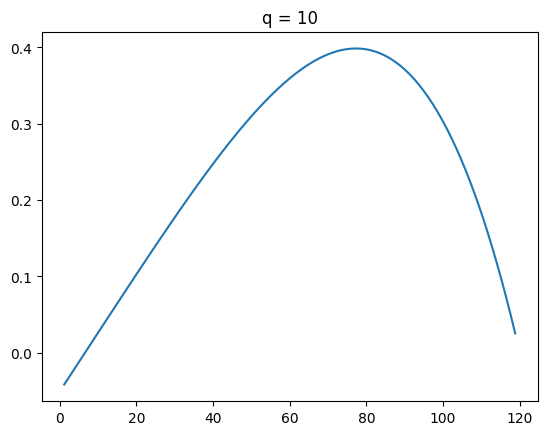

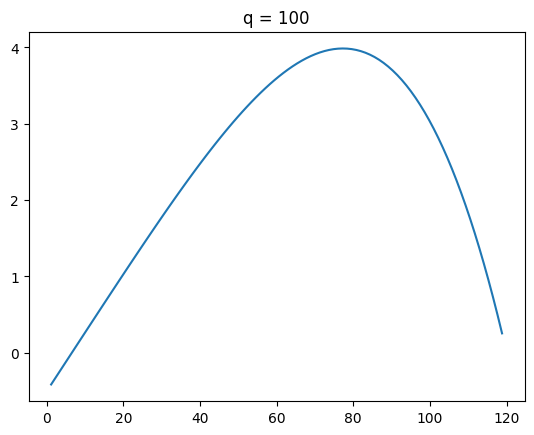

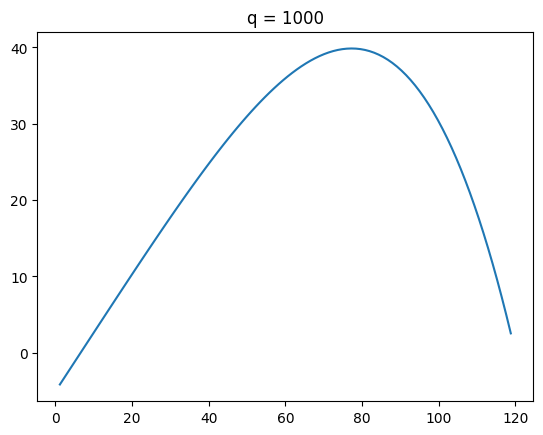

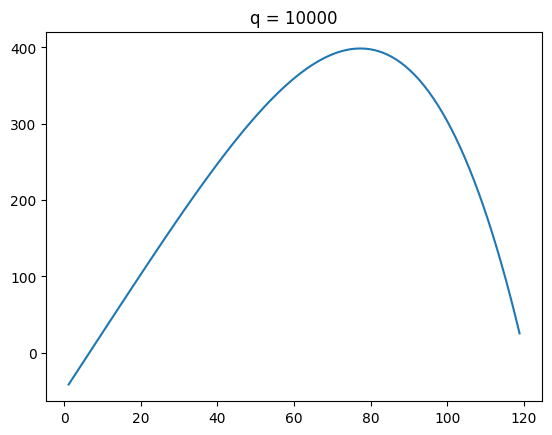

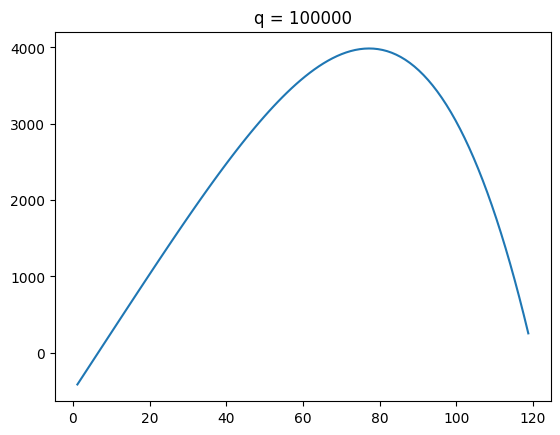

In [9]:
for q in [10, 10**2, 10**3, 10**4, 10**5]:
    b = b_vector(x, n, q, E, I, h, l)
    y = np.linalg.solve(A,b)
    plt.title("q = " + str(q))
    plt.plot(x[1:-1],y)
    plt.show()

### (b)
$$w_n'' = [1+(w_n')^2]^{3/2}\left(\frac{S}{EI}w_n + \frac{qx}{2EI}(x-l)\right), \hspace{5px} 0<x<l$$ 

In [10]:
n = 100 #number of intervals

h = l/(n+1)
x = [i*h for i in range(0,n+2)] #nodes

In [74]:
def derivative_newton(u, x):
    u1, u2, z1, z2 = u
    u1 = u2
    u2 = (1+u2**2)**(3/2)*((S/(E*I))*u1 + ((q*x)/(2*E*I))*(x-l))
    z1 = z2
    z2 = (1+u2**2)**(3/2)*(S/(E*I))*z1 + 3*(1+u2**2)*u2*((S/(E*I))*u1+((q*x)/(2*E*I))*(x-l))
    return np.array([u1, u2, z1, z2])

def derivative_secant(u, x):
    u1, u2 = u
    u1 = u2
    u2 = (1+u2**2)**(3/2)*((S/(E*I))*u1 + ((q*x)/(2*E*I))*(x-l))
    return np.array([u1, u2])

In [77]:
def runge_kutta(f, y0, t0, h, n):
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(1, n):
        t = t0 + h*i
        k1 = f(y[i-1], t)
        k2 = f(y[i-1] + k1*(h/2), t + h/2)
        k3 = f(y[i-1] + k2*(h/2), t + h/2)
        k4 = f(y[i-1] + k3*h, t + h)
        y[i] = y[i-1] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return y

def shooting_method_newton(f, t0, h, n, b):
    lmbda_last = np.inf
    lmbda = 0 #initial guess
    y0 = [0, lmbda, 0, 1]
    y = runge_kutta(f, y0, t0, h, n)
    while abs(lmbda_last - b) > 1e-6:
        lmbda_last = lmbda
        lmbda = lmbda - (y[-1][0] - b)/y[-1][2]
        y0 = [0, lmbda, 0, 1]
        y = runge_kutta(f, y0, t0, h, n)
    return y

def shooting_method_secant(f, t0, h, n, b):
    lmbda_last = 0 #initial guess
    y0 = [0, lmbda_last]
    y_tminus1 = runge_kutta(f, y0, t0, h, n)
    y0 = [0, lmbda_last + 1]
    y_t = runge_kutta(f, y0, t0, h, n)
    while abs(lmbda_last - b) > 1e-6:
        lmbda_last = lmbda
        lmbda = lmbda - (y_t[-1][0] - b)*(lmbda - lmbda_last)/(y_t[-1][0] - y_tminus1[-1][0])
        y_tminus1 = y_t
        y0 = [0, lmbda]
        y_t = runge_kutta(f, y0, t0, h, n)
    return y


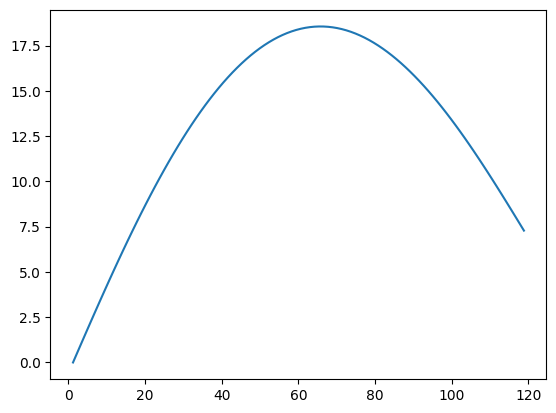

In [65]:
y = shooting_method_newton(derivative_newton, 0, h, n, 0)
plt.plot(x[1:-1], y[:,0])

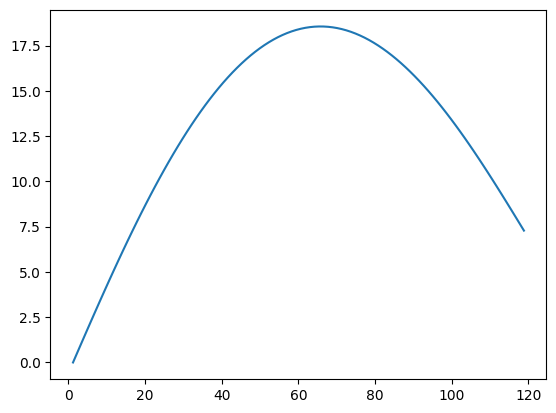

In [79]:
y = shooting_method_secant(derivative_secant, 0, h, n, 0)
plt.plot(x[1:-1], y[:,0])

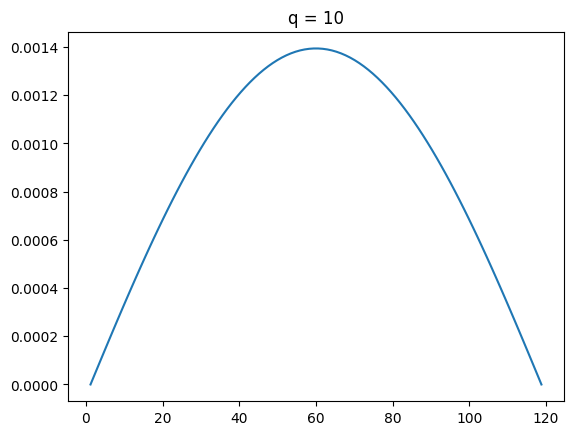

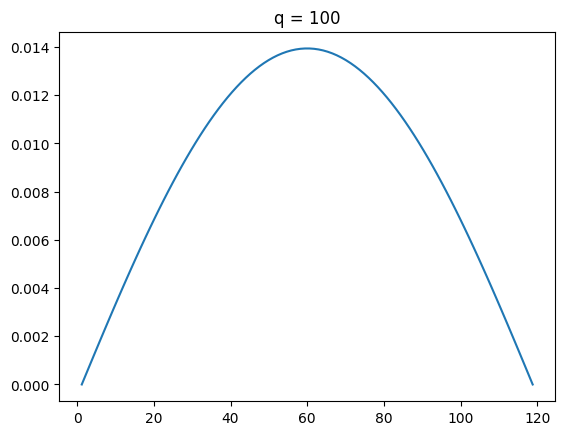

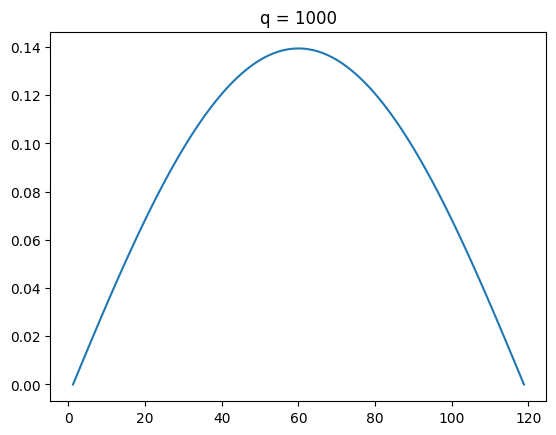

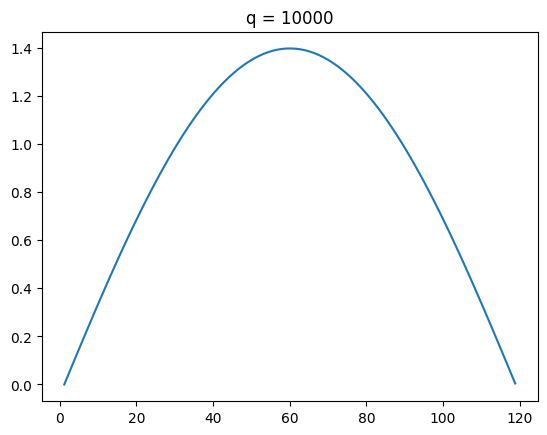

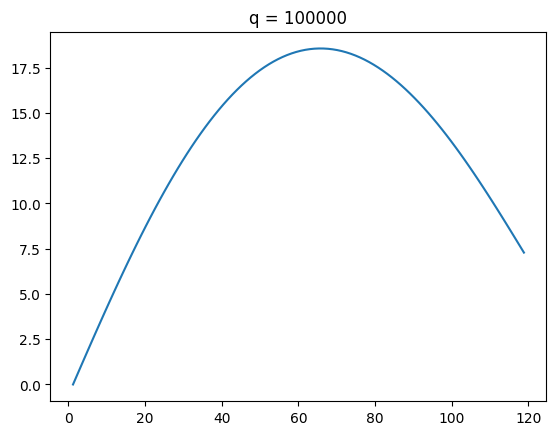

In [70]:
for charge in [10, 10**2, 10**3, 10**4, 10**5]:
    q = charge
    y = shooting_method_newton(derivative_newton, 0, h, n, 0)
    plt.title("q = " + str(q))
    plt.plot(x[1:-1], y[:,0])
    plt.show()